# 한국어 QA 모델 만들기

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

<br><br><br>

# 1. 데이터 로드

In [25]:
DATA_DIR = os.getenv("HOME") + '/aiffel/gd_14_babi_memory_net/e-28-korean/'
TRAIN_FILE = os.path.join(DATA_DIR, 'qa1_single-supporting-fact_train_kor.txt')
TEST_FILE = os.path.join(DATA_DIR, 'qa1_single-supporting-fact_test_kor.txt')

In [26]:
# 훈련데이터에서 20개 문장 출력
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


<br><br><br>

# 2. 데이터 전처리

In [27]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [28]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [29]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [30]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [31]:
print(train_stories[2])
print(train_questions[2])
print(train_answers[2])

['필웅이는 화장실로 갔습니다.', '은경이는 복도로 이동했습니다.', '수종이는 복도로 복귀했습니다.', '경임이는 정원으로 갔습니다.', '은경이는 사무실로 갔습니다.', '경임이는 화장실로 뛰어갔습니다.']
수종이는 어디야? 
복도


<br><br><br>

# 2. 토크나이저

In [32]:
from ckonlpy.tag import Twitter

twitter = Twitter()

twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [33]:
twitter.morphs('은경이는 사무실로 갔습니다.')

['은경이', '는', '사무실', '로', '갔습니다', '.']

In [34]:
# 토큰화
def tokenize(sent):
    return twitter.morphs(sent)

In [35]:
# 단어장을 생성하고, 단어에서 정수로, 정수에서 단어로 맵핑하는 딕셔너리(dictionary) 생성
# 스토리와 질문의 가장 긴 길이를 구하여 패딩에 적용
# 같은 스토리 내의 여러 문장들을 하나의 문장으로 통합
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [36]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [37]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [38]:
# 실제 변수로 사용할 단어장의 크기는 패딩을 고려하여 +1을 해주어야함
vocab_size = len(word2idx) + 1

In [39]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


<br><br><br>

# 2. 형태소 분석 후 불용어 처리

In [40]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [41]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [43]:
Xstrain[0], Xqtrain[0], Ytrain[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  9,  1, 14,  3, 17,  2,  7,  1, 16,  3, 10,
         4,  2], dtype=int32),
 array([ 9,  1, 21, 22, 23], dtype=int32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [44]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape)
print(Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24)
(1000, 70) (1000, 5) (1000, 24)


<br><br><br>

# 3. 한국어에서의 모델 정확도 확인

## 3-1. 메모리네트워크 설계

In [46]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [47]:
train_epochs = 120  # 에포크 횟수
batch_size = 32     # 배치 크기
embed_size = 50     # 임베딩 크기
lstm_size = 64      # LSTM의 크기
dropout_rate = 0.30 # 과적합 방지 기법인 드롭아웃 적용 비율

In [48]:
# 입력을 담아두는 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [49]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원


# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [50]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [51]:
# 구현된 인코더를 이용해 텍스트를 임베딩으로 변환
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential/Identity:0", shape=(None, 70, 50), dtype=float32) 

Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 70, 5), dtype=float32) 

Question encoded Tensor("sequential_2/Identity:0", shape=(None, 5, 50), dtype=float32) 



In [52]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 70, 5), dtype=float32)


In [53]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 5, 70), dtype=float32)


In [54]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 5, 120), dtype=float32)


In [55]:
# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

Epoch 1/120
313/313 [==============================] - 1s 5ms/step - loss: 1.8964 - acc: 0.1674 - val_loss: 1.8106 - val_acc: 0.1710
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6933 - acc: 0.2708 - val_loss: 1.5689 - val_acc: 0.3600
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5646 - acc: 0.3312 - val_loss: 1.5282 - val_acc: 0.3330
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5228 - acc: 0.3541 - val_loss: 1.4791 - val_acc: 0.3970
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4854 - acc: 0.3773 - val_loss: 1.4570 - val_acc: 0.3980
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4653 - acc: 0.4143 - val_loss: 1.4358 - val_acc: 0.4430
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4352 - acc: 0.4436 - val_loss: 1.3993 - val_acc: 0.4710
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.2522 - acc: 0.9099 - val_loss: 0.3999 - val_acc: 0.8590
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2376 - acc: 0.9148 - val_loss: 0.3734 - val_acc: 0.8660
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2230 - acc: 0.9219 - val_loss: 0.3790 - val_acc: 0.8680
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2046 - acc: 0.9266 - val_loss: 0.3385 - val_acc: 0.8840
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2006 - acc: 0.9300 - val_loss: 0.3219 - val_acc: 0.8880
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1804 - acc: 0.9361 - val_loss: 0.3175 - val_acc: 0.9040
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1649 - acc: 0.9436 - val_loss: 0.2859 - val_acc: 0.9100
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [56]:
# 훈련 후 모델 저장
model_path = os.getenv('HOME')+'/aiffel/gd_14_babi_memory_net/model_1.h5'
model.save(model_path)

In [57]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.2259 - acc: 0.9460

 테스트 정확도: 0.9460


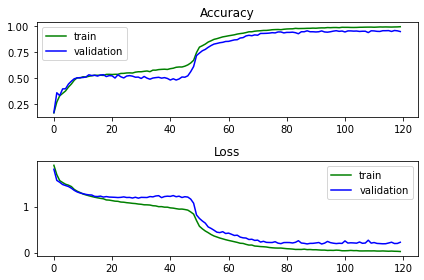

In [58]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [59]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도      복도
필웅이 는 어디 야 ?        : 화장실     화장실
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 사무실     사무실
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
은경이 는 어디 야 ?        : 부엌      부엌
은경이 는 어디 야 ?        : 정원      정원
은경이 는 어디 야 ?        : 부엌      부엌
수종이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 부엌      사무실
필웅이 는 어디 야 ?        : 복도      복도
은경이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 사무실     사무실
경임이 는 어디 야 ?        : 복도      사무실
수종이 는 어디 야 ?        : 침실      침실
경임이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
수종이 는 어디 야 ?        : 부엌      부

<br><br><br>

# 4. 불용어 제거 후 모델 정확도 확인

In [60]:
from ckonlpy.tag import Postprocessor

postprocessor = Postprocessor(
    base_tagger=twitter,
    stopwords={'는', '으로', '로', '야'}
)

In [69]:
print(twitter.pos('은경이는 사무실로 갔습니다.'))
print(postprocessor.pos('은경이는 사무실로 갔습니다.'))

[('은경이', 'Noun'), ('는', 'Josa'), ('사무실', 'Noun'), ('로', 'Josa'), ('갔습니다', 'Verb'), ('.', 'Punctuation')]
[('은경이', 'Noun'), ('사무실', 'Noun'), ('갔습니다', 'Verb'), ('.', 'Punctuation')]


In [70]:
def tokenize(sent):
    return [x[0] for x in postprocessor.pos(sent)]

In [71]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [72]:
print(word2idx)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '?': 19}


In [73]:
# 실제 변수로 사용할 단어장의 크기는 패딩을 고려하여 +1을 해주어야함
vocab_size = len(word2idx) + 1

In [74]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 50
질문의 최대 길이 : 3


In [75]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [76]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape)
print(Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 50) (10000, 3) (10000, 20)
(1000, 50) (1000, 3) (1000, 20)


### 모델

In [77]:
# 입력을 담아두는 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_3:0", shape=(None, 50), dtype=float32)
Question: Tensor("input_4:0", shape=(None, 3), dtype=float32)


In [78]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원


# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [79]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [80]:
# 구현된 인코더를 이용해 텍스트를 임베딩으로 변환
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential_3/Identity:0", shape=(None, 50, 50), dtype=float32) 

Input encoded c Tensor("sequential_4/Identity:0", shape=(None, 50, 3), dtype=float32) 

Question encoded Tensor("sequential_5/Identity:0", shape=(None, 3, 50), dtype=float32) 



In [81]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation_2/Identity:0", shape=(None, 50, 3), dtype=float32)


In [82]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute_1/Identity:0", shape=(None, 3, 50), dtype=float32)


In [83]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate_1/Identity:0", shape=(None, 3, 100), dtype=float32)


In [84]:
# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.8817 - acc: 0.1744 - val_loss: 1.8062 - val_acc: 0.1570
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7853 - acc: 0.1913 - val_loss: 1.7239 - val_acc: 0.2370
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6603 - acc: 0.3011 - val_loss: 1.5915 - val_acc: 0.3550
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5595 - acc: 0.3598 - val_loss: 1.5105 - val_acc: 0.3730
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5159 - acc: 0.3861 - val_loss: 1.4717 - val_acc: 0.3870
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4964 - acc: 0.3926 - val_loss: 1.4783 - val_acc: 0.4020
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4375 - acc: 0.4289 - val_loss: 1.3922 - val_acc: 0.4390
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.2734 - acc: 0.8986 - val_loss: 0.2808 - val_acc: 0.9010
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2637 - acc: 0.9048 - val_loss: 0.2515 - val_acc: 0.9080
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2574 - acc: 0.9074 - val_loss: 0.2413 - val_acc: 0.9130
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2580 - acc: 0.9096 - val_loss: 0.2474 - val_acc: 0.9120
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2580 - acc: 0.9062 - val_loss: 0.2293 - val_acc: 0.9150
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2458 - acc: 0.9143 - val_loss: 0.2357 - val_acc: 0.9220
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2346 - acc: 0.9153 - val_loss: 0.2477 - val_acc: 0.9090
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [85]:
# 훈련 후 모델 저장
model_path = os.getenv('HOME')+'/aiffel/gd_14_babi_memory_net/model_2.h5'
model.save(model_path)

In [86]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1919 - acc: 0.9400

 테스트 정확도: 0.9400


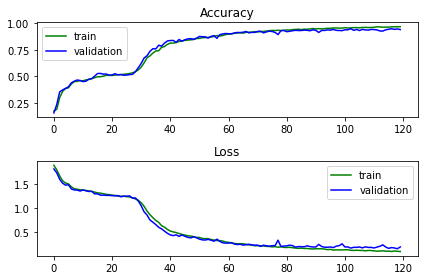

In [87]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [88]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 어디 ?            : 복도      복도
필웅이 어디 ?            : 화장실     화장실
경임이 어디 ?            : 부엌      부엌
경임이 어디 ?            : 복도      복도
경임이 어디 ?            : 부엌      부엌
경임이 어디 ?            : 복도      복도
경임이 어디 ?            : 정원      정원
수종이 어디 ?            : 복도      복도
경임이 어디 ?            : 사무실     정원
수종이 어디 ?            : 사무실     사무실
필웅이 어디 ?            : 부엌      부엌
필웅이 어디 ?            : 정원      정원
수종이 어디 ?            : 사무실     사무실
필웅이 어디 ?            : 침실      침실
필웅이 어디 ?            : 침실      침실
은경이 어디 ?            : 부엌      부엌
은경이 어디 ?            : 정원      정원
은경이 어디 ?            : 부엌      부엌
수종이 어디 ?            : 사무실     사무실
은경이 어디 ?            : 부엌      부엌
필웅이 어디 ?            : 복도      복도
은경이 어디 ?            : 사무실     사무실
은경이 어디 ?            : 사무실     사무실
경임이 어디 ?            : 복도      복도
수종이 어디 ?            : 침실      침실
경임이 어디 ?            : 침실      침실
필웅이 어디 ?            : 침실      침실
수종이 어디 ?            : 부엌      부엌
수

<br><br><br>

# 회고
- 불용어를 제거한 것과 아닌 것의 차이는 크게 없어보인다. 사전의 크기도 작은 것도 한 몫을 한 것인가 싶다.